In [1]:
from mesh_library import *

In [2]:
#meshio.write("mesh.msh", mesh, file_format="gmsh22")

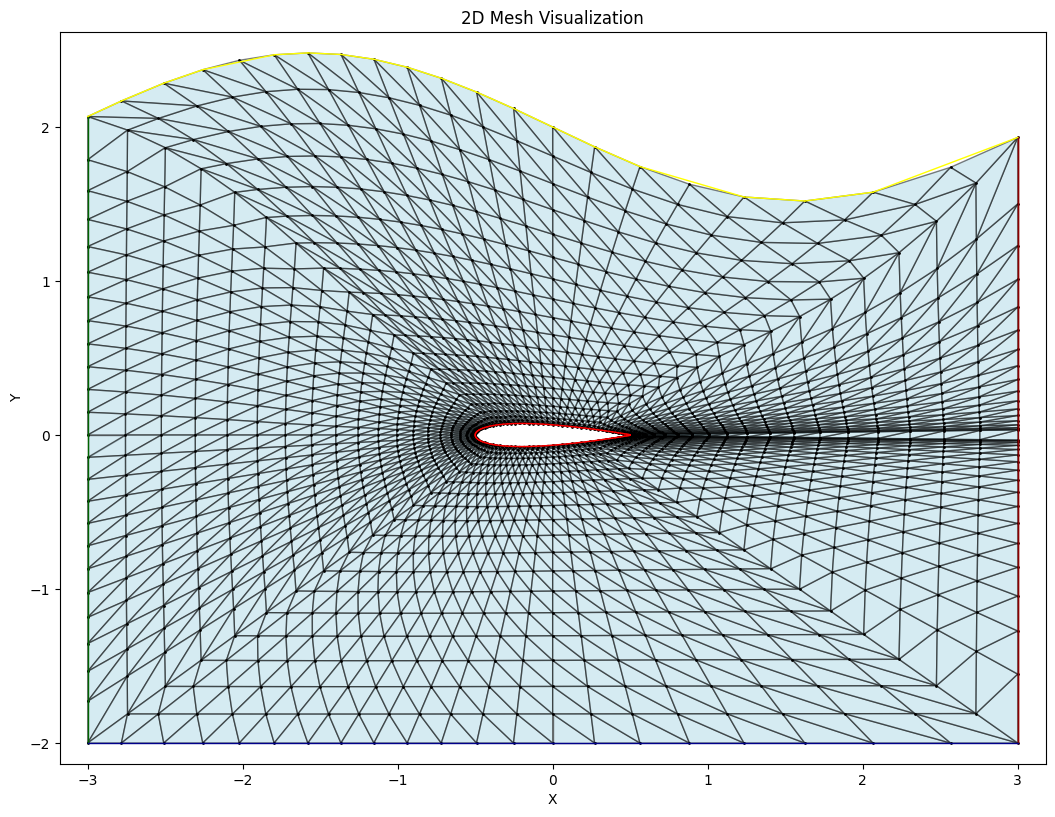

In [118]:
mesh = NACA_mesh(100,20,"0015", "triangle", angle_of_attack=0)
plot_mesh(shift_surface(mesh, lambda x:2, lambda x:2 - 0.5*np.sin(x)))

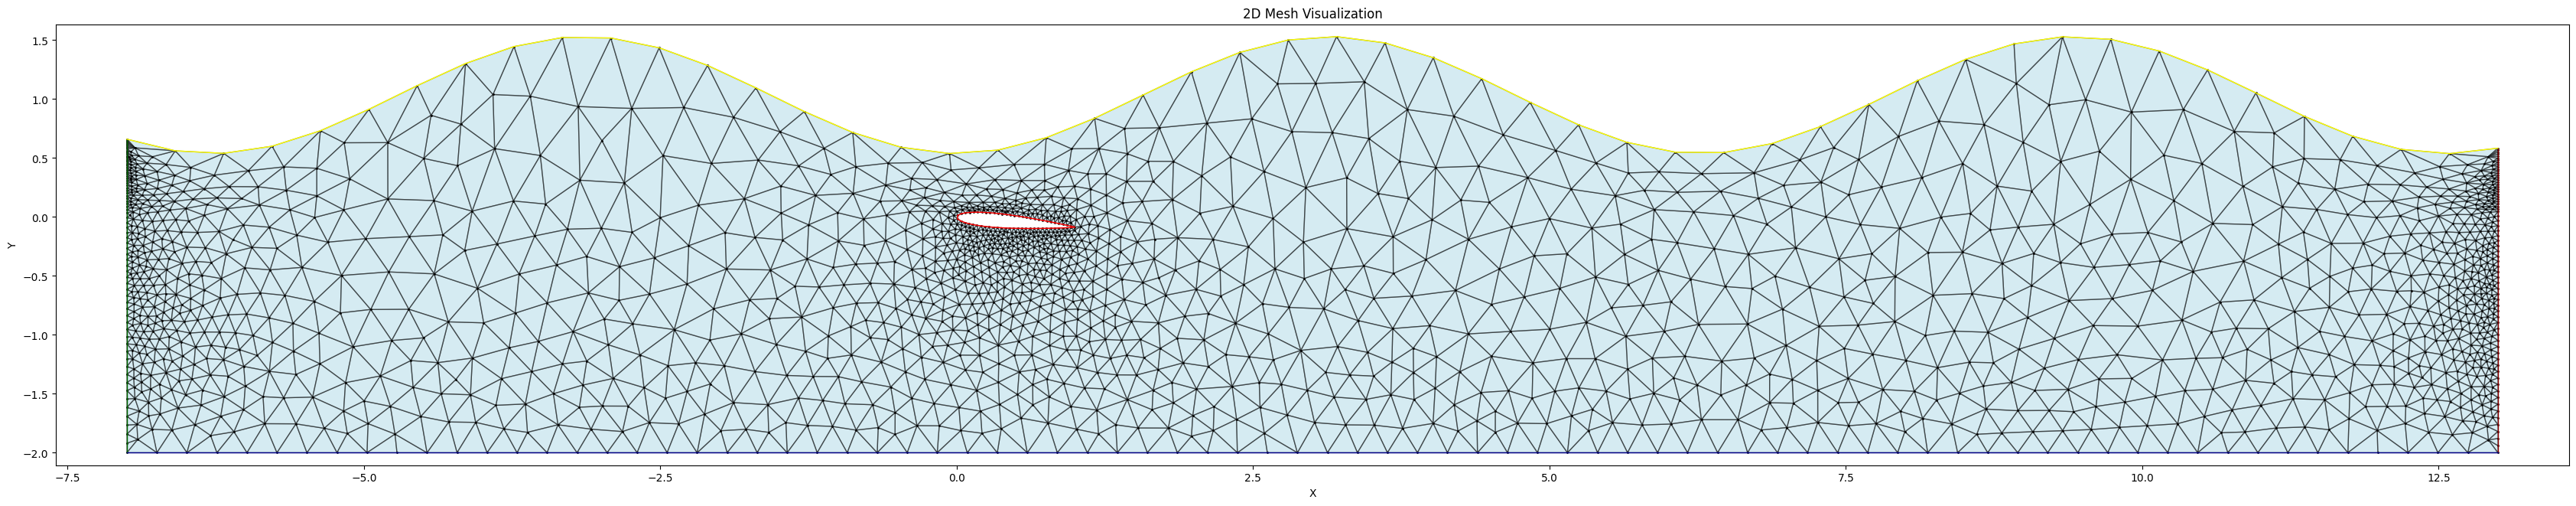

In [115]:
mesh = meshio.read("naca_low_quality.msh")
plot_mesh(shift_surface(mesh, lambda x:1, lambda x:1 - 0.5*np.cos(x)))